### 大まかな課題の内容
ウイルス感染が広まるシミュレーション.

### 設計
- virus_parameterクラス
    このクラスはウイルスに関するパラメータを扱います.具体的には以下のようなパラーメータを持ちます
    
    - 死亡率
    - 潜伏期間
   
このウイルスはCOVID19をモデルとしているのでデータから年齢に関する死亡率関数を近似し,採用する.今回は簡易的なモデルにとどめるつもりなので基礎疾患やマスクしてるしてないは考慮せず,上記の基本的な部分のみにとどめる
- personクラス
    このクラスはその名の通り,人のエージェントクラス.personクラスはvirus_parameterクラスを継承し,以下のようなパラメータを持つ
    
    - 年齢
    - 座標
    - その人の状態を示すフラグ
   
### ToDo
- [x] エージェント同士の距離を計算するメソッド
- [x] 任意の人数を初期状態で感染状態にしとく
- [x] 感染が広がっていないので,そこら辺のデバッグ
- [x] なぜか初っ端から免疫持ってるやつがおるのでその辺の原因追及
- [x] 治った人や免疫持ちが止まったままになってる...
- [ ] 感染者数を縦軸,横軸を時間にしてグラフをプロット
- [ ] 死者に関する情報

<IPython.core.display.Javascript object>


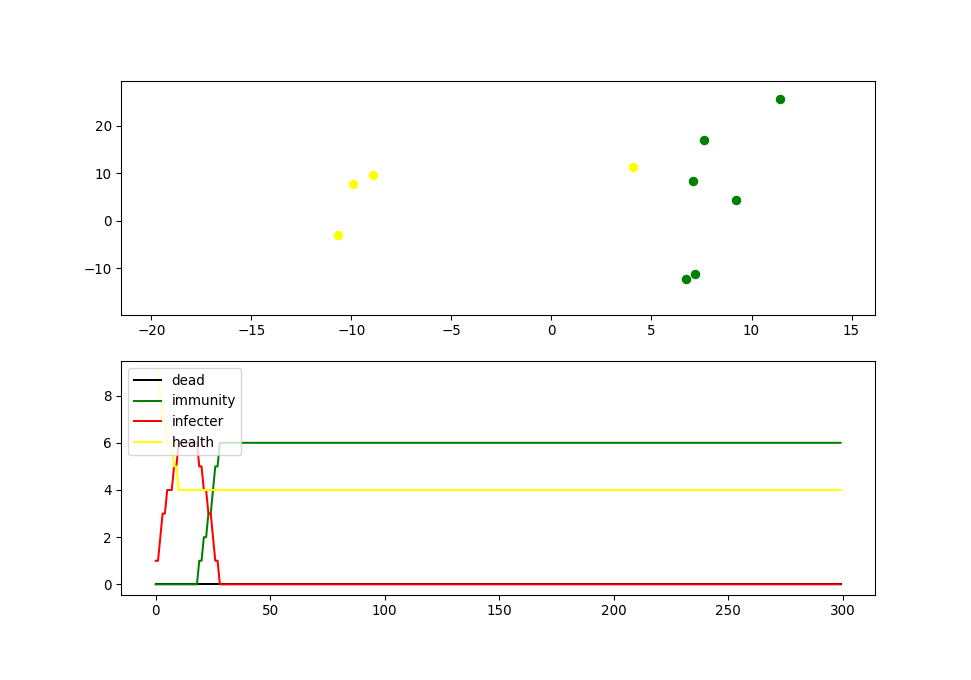

何人を想定しますか:10
初期感染人数:1
age: 38, mortality rate: 0.0011
age: 19, mortality rate: 0.0008
age: 44, mortality rate: 0.0015
age: 31, mortality rate: 0.0012
age: 42, mortality rate: 0.0012
age: 60, mortality rate: 0.0173
age: 64, mortality rate: 0.0281
age: 76, mortality rate: 0.0848
age: 21, mortality rate: 0.0008
age: 46, mortality rate: 0.0019


In [38]:
%matplotlib nbagg
#%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dead_flag = 0b010
immunity_flag = 0b100
infect_flag = 0b001
social_distance = 2.0
DUARING_TREATMENT = 14 ## 治療を受ける期間
MAX_DAYS = 300
INF = 1e10

fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(2, 1, 1)

ims = []
deads = [0 for i in range(MAX_DAYS)] ## 1日ごとに死んだ人間の数を保存
immunities = [0 for i in range(MAX_DAYS)] ## 1日ごとに免疫獲得者の数を保存
uninfected = [0 for i in range(MAX_DAYS)] ## 1日ごとに,未感染者の数を保存
infected = [0 for i in range(MAX_DAYS)] ## 1日ごとに,感染者の数を保存

class virus_parameter:
    def __init__(self, age:int):
        self.mortality_rate       = (0.09850815850821255 + 0.03130675990674487*age - 0.005947878787877348*age**2 + \
        0.000392896270396206*age**3 - 0.00001153846153846006*age**4 +\
        1.5038461538459874e-7*age**5 - 6.666666666665943e-10*age**6) / 100.0 ##死亡率
        self.incubation_period    = random.randint(1, 14) ##潜伏期間
        self.fever_period = 0 ##発症から日数の経過
    
class person(virus_parameter):
    def __init__(self, is_infected: bool):
        self.age = int(abs(random.normalvariate(46, 23)))
        super().__init__(self.age)
        print('age: {0:2d}, mortality rate: {1:.4f}'.format(self.age, self.mortality_rate))
        ##stateは免疫獲得,死亡,感染のフラグ.0b101なら感染したが免疫獲得.0b011なら感染して死亡,0b000ならそもそも感染してない, 0b001なら感染状態
        ##まとめるとstateが取り得る状態としては
        ##0b000:感染してない
        ##0b001:感染してる
        ##0b011:感染して死亡
        ##0b100:感染したが免疫を獲得(完治)
        self.state = 0b001 if is_infected else 0b000
        self.position = {'x': random.uniform(-20., 20.), 'y': random.uniform(-20., 20.)}
        self.ID = random.randint(0, 10000000)
        
    ## 死んでいたらtrue 生きてたらfalse
    def is_dead(self) -> bool:
        return self.state & dead_flag
    
    ## 免疫を持ってたらtrue 持ってなかったらfalse
    def has_immunity(self) -> bool:
        return self.state & immunity_flag
    
    ## 保菌者ならtrue そうでなければfalse
    def has_virus(self) -> bool:
        return self.state & infect_flag
        
    def get_immunity(self) -> None:
        ## 免疫を獲得すれば感染フラグも下ろす
        self.state |= immunity_flag
        self.state &= ~infect_flag
        
    def go_to_the_heaven(self) -> None:
        ## 宿主が死ぬとウイルスも死ぬので感染フラグを下ろす
        self.state |= dead_flag
        self.state &= ~infect_flag

    def infected(self, nearest, distance: float) -> None:
        ## 一番近くの人がソーシャルディスタンス内に存在していて,相手が保菌者で自分が免疫を持ってない場合に感染
        if distance < social_distance and nearest.has_virus() and not(self.has_immunity()):
            self.state |= infect_flag
        else:
            pass
    
    ## virus_parameterで定義されている死亡率に従って死亡か否かを決める
    def dead_or_alive(self) -> None:
        if self.mortality_rate >= random.random():
            self.go_to_the_heaven()
        else:
            self.get_immunity()
            
    def dist(self, agent2) -> float:
        return np.sqrt((self.position['x'] - agent2.position['x']) ** 2 + (self.position['x'] - agent2.position['x']) ** 2)

    ##今回,人は1日に1歩,歩くことにする
    def walk(self) -> None:
        ##死人や病人は歩かない
        if self.is_dead() or (self.fever_period > 0 and self.has_virus()): 
            return
        
        else:
            self.position['x'] += random.uniform(-1.0, 1.0)
            self.position['y'] += random.uniform(-1.0, 1.0)
            #self.incubation_period = self.incubation_period - 1 if self.has_virus() and self.incubation_period > 0 else 0
    
    def update(self, agentlist: list, personal_id: int) -> None:
        ##感染してない人の処理
        if not(self.has_virus()):
            min_dist = INF
            nearest_person = None
            for agent in agentlist:
                ## 自分自身との距離計算してもしゃあないので
                if(agent.ID == personal_id):
                    continue
                #一番近くにいる人の情報を保持
                if min_dist > self.dist(agent):
                    min_dist = self.dist(agent)
                    #print('min_dist = {0}'.format(min_dist))
                    nearest_person = agent
            
            #print('My id is {}, nearest\'s id is {}'.format(id(self), id(nearest_person)))
            #print('min_dist = {}'.format(min_dist))
            self.infected(nearest_person, min_dist)
            
        ## ご逝去あそばされた方,完治された方は特段処理はなし
        elif self.is_dead() or self.has_immunity():
            pass
        
        ## 感染したけど死亡も免疫も獲得してない人
        elif self.has_virus():
            ## 潜伏期間中なら発症までのタイムリミットが迫る!!
            if self.incubation_period > 0:
                self.incubation_period -= 1
            ## 発症中ならdead or aliveの日までのタイムリミットが迫る!!
            elif self.fever_period < DUARING_TREATMENT:
                self.fever_period += 1
            ## 発熱から14日後に運命の日が決まる.
            elif self.fever_period >= DUARING_TREATMENT:
                self.dead_or_alive()
            
def show_agents(agentlist: list):
    uninfect = [] ## 未感染
    infect   = [] ## 感染者
    dead     = [] ## 死亡者
    immunity = [] ## 免疫持ち
    for agent in agentlist:
        ## 死んだ人は黒
        if agent.is_dead():
            dead += [ax1.scatter(agent.position['x'], agent.position['y'], c='black', label='dead')]
        ## 抗体は持ってないが感染してる人は赤
        elif agent.has_virus() and not(agent.has_immunity()):
            infect += [ax1.scatter(agent.position['x'], agent.position['y'], c='red', label='infector')]
        ## 抗体もってる人は緑
        elif agent.has_immunity() and not(agent.has_virus()):
            immunity += [ax1.scatter(agent.position['x'], agent.position['y'], c='green', label='immunity')]
        ## 未感染者は黄色
        else:
            uninfect += [ax1.scatter(agent.position['x'], agent.position['y'], c='yellow', label='health')]
        #ax1.legend()
    return uninfect + infect + dead + immunity

## 1日ごとに死者,免疫獲得者, 感染者, 健常者の人数を数える
def get_information(agentlist: list, index: int) -> None:
    for agent in agentlist:
        if agent.is_dead():
            deads[index] += 1
        elif agent.has_immunity():
            immunities[index] += 1
        elif agent.has_virus():
            infected[index] += 1
        else:
            uninfected[index] += 1

if __name__ == '__main__':
    people               = int(input('何人を想定しますか:'))
    infected_people      = int(input('初期感染人数:'))
    agentlist = [person(False) for i in range(people-infected_people)]
    agentlist += [person(True) for i in range(infected_people)]
    for i in range(MAX_DAYS):
        ##全員の位置を更新
        for agent in agentlist:
            agent.walk()
            #agent.update(agentlist, agent.ID)
        ##全員の状態を更新
        for agent in agentlist:
            agent.update(agentlist, agent.ID)
        
        ims.append(show_agents(agentlist))
        get_information(agentlist, i)
        
    ani = animation.ArtistAnimation(fig, ims)
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot([i for i in range(MAX_DAYS)], deads, c='black', label='dead')
    ax2.plot([i for i in range(MAX_DAYS)], immunities, c='green', label='immunity')
    ax2.plot([i for i in range(MAX_DAYS)], infected, c='red', label='infecter')
    ax2.plot([i for i in range(MAX_DAYS)], uninfected, c='yellow', label='health')
    ax2.legend()
    #fig.savefig('COVID19_10_1.png')
    plt.show()

In [ ]:
import matplotlib.pyplot
x = [i for i in range(10)]
y = [i**2 for i in range(10)]
print(type(plt.plot(x, y)))
plt.show()